# Installation 
#### Anaconda 3-4.2.0 (or higher)
#### Create virtual environment >> conda create -n yourenvname
#### Activate virtual environment >>  conda activate yourenvname
#### Install torchvision (Installs pytorch too) >> conda install -c pytorch torchvision
#### Open Jupyter notebook >> jupyter notebook

In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
import cv2 as cv
# from skimage import io

## Input Transformation
#### Convert the Numpy arrays to PyTorch tensors and normalize input

In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

## Loading dataset
#### This is a built-in demo. Creating your own custom dataloader is discussed later

## Constructing the network

In [3]:
class customDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.label = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.label.iloc[idx, 0])
#         print(img_name)
        image = cv.equalizeHist(cv.imread(img_name, cv.IMREAD_GRAYSCALE))/255.0
        labels = self.label.iloc[idx, 1]
        labels = np.array([labels])
        labels = labels.astype('float').reshape(-1, 1)
        sample = {'image': image, 'label': labels}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [4]:
custom_dataset = customDataset(csv_file='labels2.csv',
                                    root_dir='/home/dhull/vision/ass4/')
imgs = []
lbls = []

for i in range(len(custom_dataset)):
    sample = custom_dataset[i]
    imgs.append([sample['image']])
    lbls.append(sample['label'][0][0])
imgs = np.asarray(imgs).astype(float)
lbls = np.asarray(lbls)

In [5]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 7)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(1296, 500)  
        self.fc2 = nn.Linear(500, 100)
        self.fc3 = nn.Linear(100, 4)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()

### Original for white:
Net(  
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))  
  (conv2): Conv2d(6, 16, kernel_size=(7, 7), stride=(1, 1))  
  (fc1): Linear(in_features=1296, out_features=500, bias=True)  
  (fc2): Linear(in_features=500, out_features=100, bias=True)  
  (fc3): Linear(in_features=100, out_features=4, bias=True)  
)

In [6]:
net.load_state_dict(torch.load("initial.m"))

<All keys matched successfully>

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Training the network

In [11]:
len(imgs)

3611

[1,   100] loss: 1.380
[1,   200] loss: 1.353
[1,   300] loss: 1.321
[1,   400] loss: 1.261
[1,   500] loss: 1.178
[1,   600] loss: 1.204
[1,   700] loss: 1.104
[1,   800] loss: 0.925
[1,   900] loss: 1.074
[1,  1000] loss: 0.857
[1,  1100] loss: 0.892
[1,  1200] loss: 0.784
[1,  1300] loss: 0.602
[1,  1400] loss: 0.572
[1,  1500] loss: 0.314
[1,  1600] loss: 0.715
[1,  1700] loss: 0.231
[1,  1800] loss: 0.530
[1,  1900] loss: 0.411
[1,  2000] loss: 0.272
[1,  2100] loss: 0.184
[1,  2200] loss: 0.232
[1,  2300] loss: 0.224
[1,  2400] loss: 0.255
[1,  2500] loss: 0.186
[1,  2600] loss: 0.092
[1,  2700] loss: 0.165
[1,  2800] loss: 0.195
[2,   100] loss: 0.077
[2,   200] loss: 0.086
[2,   300] loss: 0.073
[2,   400] loss: 0.093
[2,   500] loss: 0.046
[2,   600] loss: 0.133
[2,   700] loss: 0.030
[2,   800] loss: 0.055
[2,   900] loss: 0.229
[2,  1000] loss: 0.155
[2,  1100] loss: 0.043
[2,  1200] loss: 0.020
[2,  1300] loss: 0.037
[2,  1400] loss: 0.061
[2,  1500] loss: 0.014
[2,  1600] 

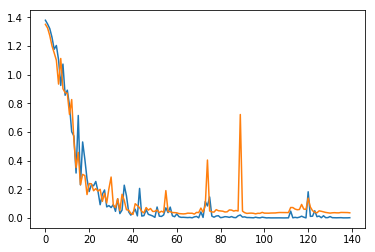

In [8]:
mini_batch = 100
loss_values = []
test_values = []
train_size = int(0.8*len(imgs))
test_size = len(imgs) - train_size
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    
    for i in range(train_size):
        # get the inputs; data is a list of [inputs, labels]
        inputs = torch.from_numpy(np.asarray([imgs[i]])).float()
        label = torch.from_numpy(np.asarray([lbls[i]])).long()
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % mini_batch == mini_batch-1:    # print every 200 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / mini_batch))
            total = 0
            correct = 0
            test_loss = 0.0
            for j in range(train_size,len(imgs)):
                # get the inputs; data is a list of [inputs, labels]
                inputs = torch.from_numpy(np.asarray([imgs[j]])).float()
                labels = torch.from_numpy(np.asarray([lbls[j]])).long()

                # forward + backward + optimize
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
            test_values.append(test_loss/test_size)
            loss_values.append(running_loss/mini_batch)
            running_loss = 0.0
        
plt.plot(loss_values)
plt.plot(test_values)

print('Finished Training')

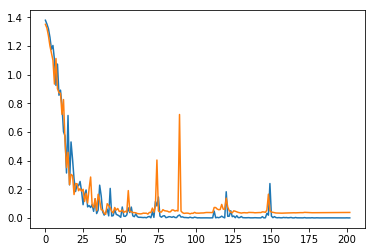

In [13]:
plt.plot(loss_values)
plt.plot(test_values)

In [9]:
torch.save(net.state_dict(), "part2.m")

## Chenking Train and Test accuracies

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for i in range(len(imgs)):
        # get the inputs; data is a list of [inputs, labels]
        inputs = torch.from_numpy(np.asarray([imgs[i]])).float()
        labels = torch.from_numpy(np.asarray([lbls[i]])).long()
        
        # forward + backward + optimize
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the train images: %d %%' % (
    100 * correct / total))

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

## Making your own custom Dataloader

In [ ]:
imgs.shape

In [ ]:
torch_imgs.shape